# Task 3: Forecasting Brent Oil Prices

In this notebook, we will develop a forecasting model for Brent oil prices. This involves:
1. Checking for stationarity in the time series data.
2. Preparing the data for model training and testing.
3. Building a time series forecasting model, starting with ARIMA.

In [1]:
# Import necessary libraries
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import scipy.stats as stats
# from pmdarima import auto_arima
os.chdir(r'c:\users\ermias.tadesse\10x\Oil-Price-Insights')  # Set the working directory to the project root
# Load the Brent Oil Prices dataset
file_path = 'Data/Raw/BrentOilPrices.csv'

# Load the Brent Oil Prices dataset
# data = pd.read_csv('../Data/BrentOilPrice.csv', index_col='Date', parse_dates=True)
data = pd.read_csv(file_path)
data = data[['Price']].dropna()


In [2]:
# Perform the ADF test for stationarity
result = adfuller(data['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpretation of the result
if result[1] > 0.05:
    print("The data is likely non-stationary. Consider differencing for stationary models.")
else:
    print("The data is likely stationary.")


ADF Statistic: -1.993856011392467
p-value: 0.2892735048934032
The data is likely non-stationary. Consider differencing for stationary models.


In [3]:
# Split data into train and test sets (e.g., 80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print(f"Training data points: {len(train)}, Testing data points: {len(test)}")


Training data points: 7208, Testing data points: 1803


### Step 3: Building the ARIMA Model

We will build an ARIMA model for forecasting Brent oil prices. The steps include:
1. Using auto_arima to find the best (p, d, q) parameters.
2. Fitting the ARIMA model with the training data.
3. Forecasting and evaluating the model performance on the test data.


In [4]:


# Define the range of p, d, q values to try
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

# Grid search to find the best parameters
best_aic = float("inf")
best_order = None
best_model = None

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")


Best ARIMA order: (2, 1, 3) with AIC: 21254.375910704497


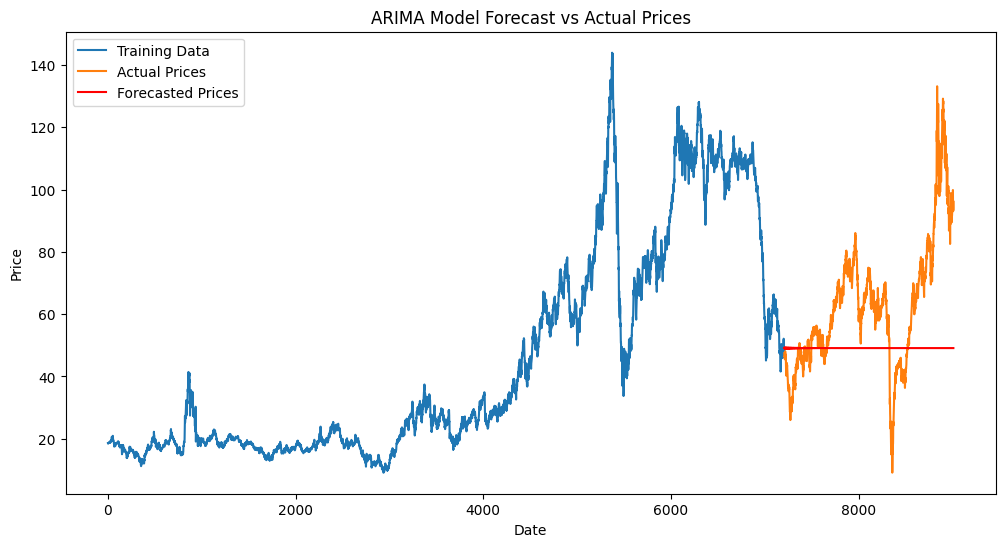

In [5]:
# Use the best order found from the grid search
p, d, q = best_order
arima_model = ARIMA(train, order=(p, d, q))
arima_model_fit = arima_model.fit()

# Forecast the test set
forecast = arima_model_fit.forecast(steps=len(test))
forecast.index = test.index

# Plotting the forecast against actual prices
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Prices')
plt.plot(forecast, label='Forecasted Prices', color='red')
plt.title("ARIMA Model Forecast vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [6]:
# Evaluate the model's performance
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 613.4690649804356
Mean Absolute Error: 18.430844823559184


### Step 4: Residual Diagnostics and Baseline Comparison

We will:
1. Analyze residuals to ensure that they are randomly distributed (indicating a good model fit).
2. Compare our ARIMA model with a simple baseline model to see if it adds value over a naive forecast.

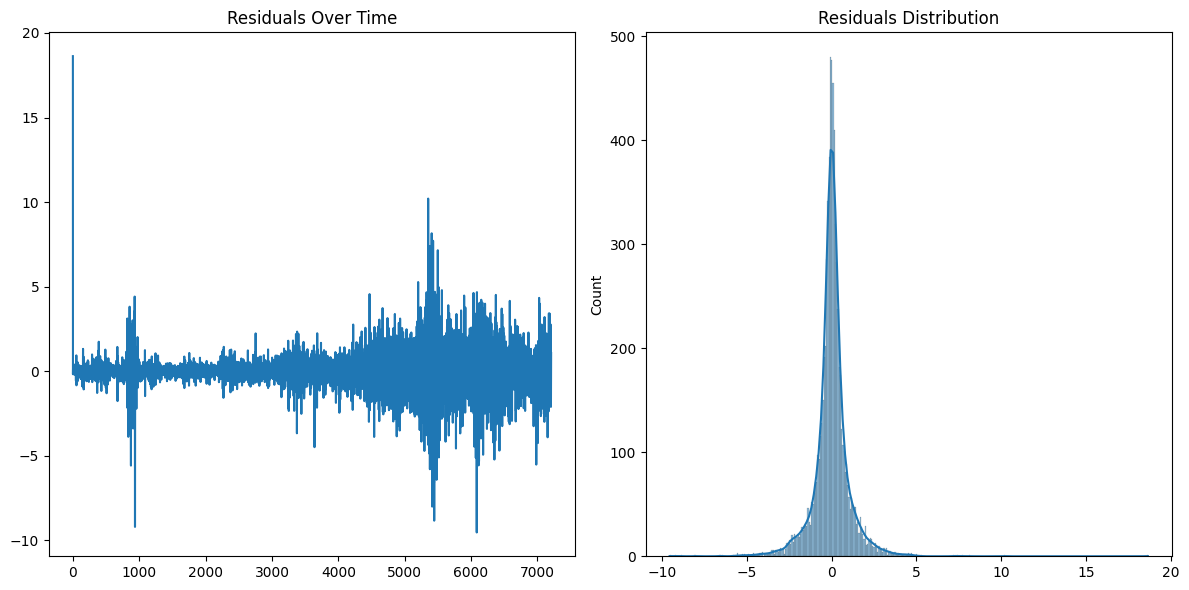

Normality test p-value: 0.0
Residuals may not be normally distributed.


In [7]:
# Plot residuals
residuals = arima_model_fit.resid

plt.figure(figsize=(12, 6))

# Plot residuals over time
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title("Residuals Over Time")

# Plot residuals histogram
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")

plt.tight_layout()
plt.show()

# Conduct normality test on residuals
k2, p = stats.normaltest(residuals)
print(f"Normality test p-value: {p}")

if p > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals may not be normally distributed.")


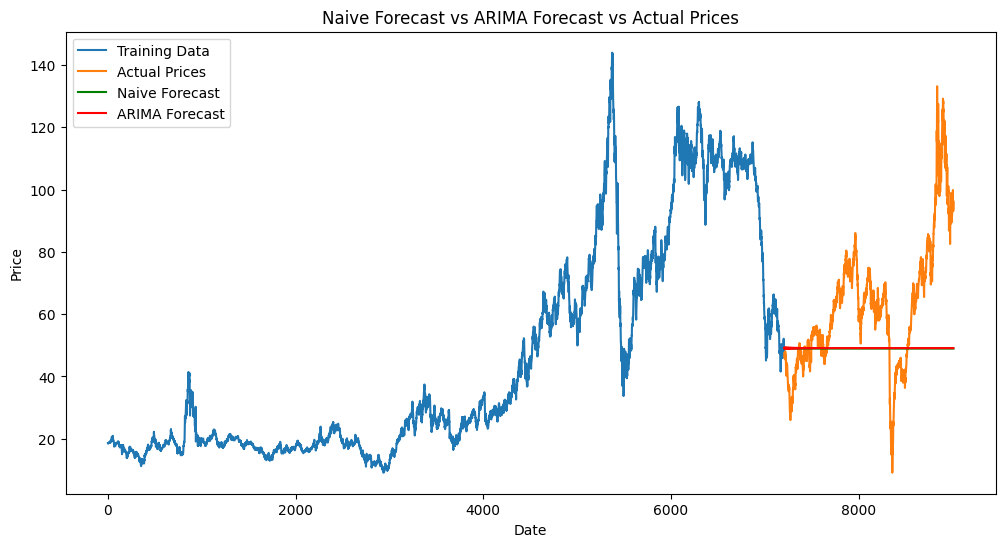

Naive Forecast - Mean Squared Error: 617.7846169717137
Naive Forecast - Mean Absolute Error: 18.501763727121464

Comparison with ARIMA Model:
ARIMA MSE: 613.4690649804356, Naive MSE: 617.7846169717137
ARIMA MAE: 18.430844823559184, Naive MAE: 18.501763727121464


In [8]:
# Naive forecast: Use the last value of the training set as the forecast for all test points
naive_forecast = [train.iloc[-1]] * len(test)

# Plot naive forecast against actual prices
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Prices')
plt.plot(test.index, naive_forecast, label='Naive Forecast', color='green')
plt.plot(forecast, label='ARIMA Forecast', color='red')
plt.title("Naive Forecast vs ARIMA Forecast vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Calculate performance metrics for naive forecast
naive_mse = mean_squared_error(test, naive_forecast)
naive_mae = mean_absolute_error(test, naive_forecast)
print(f"Naive Forecast - Mean Squared Error: {naive_mse}")
print(f"Naive Forecast - Mean Absolute Error: {naive_mae}")

# Compare ARIMA and Naive Model
print("\nComparison with ARIMA Model:")
print(f"ARIMA MSE: {mse}, Naive MSE: {naive_mse}")
print(f"ARIMA MAE: {mae}, Naive MAE: {naive_mae}")

### Step 6: Building an ETS Model (Holt-Winters Exponential Smoothing)

In this step, we will apply an ETS model using Holt-Winters Exponential Smoothing. This model is useful for time series with trend and seasonality.

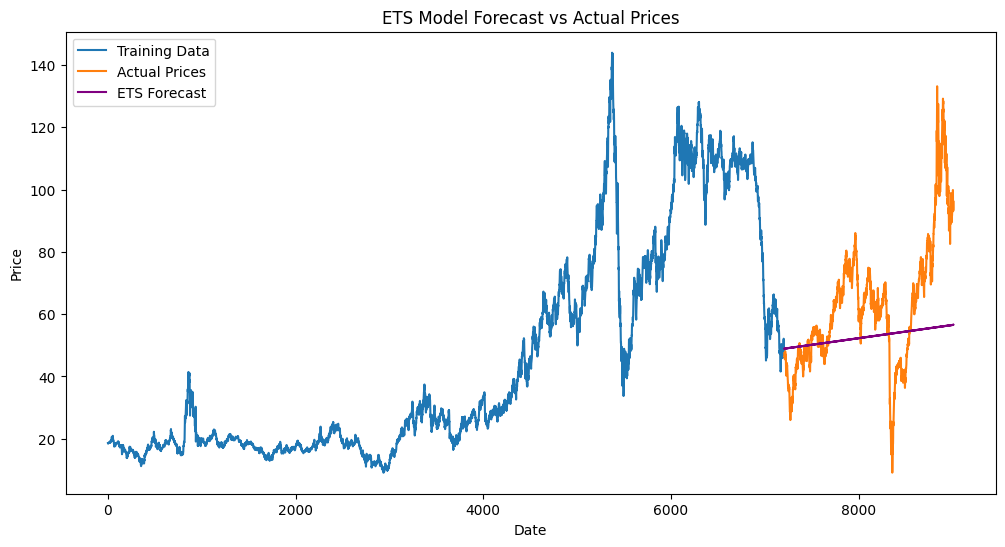

In [9]:


# Fit the ETS model with trend and seasonality
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
ets_model_fit = ets_model.fit()

# Forecast the test set
ets_forecast = ets_model_fit.forecast(steps=len(test))
ets_forecast.index = test.index

# Plot ETS forecast against actual prices
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Prices')
plt.plot(ets_forecast, label='ETS Forecast', color='purple')
plt.title("ETS Model Forecast vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [10]:
# Calculate performance metrics for ETS model
ets_mse = mean_squared_error(test, ets_forecast)
ets_mae = mean_absolute_error(test, ets_forecast)

print(f"ETS Model - Mean Squared Error: {ets_mse}")
print(f"ETS Model - Mean Absolute Error: {ets_mae}")

# Compare ETS with ARIMA and Naive Forecast
print("\nModel Comparison:")
print(f"ARIMA MSE: {mse}, ETS MSE: {ets_mse}, Naive MSE: {naive_mse}")
print(f"ARIMA MAE: {mae}, ETS MAE: {ets_mae}, Naive MAE: {naive_mae}")


ETS Model - Mean Squared Error: 475.5288010487339
ETS Model - Mean Absolute Error: 16.16868948735412

Model Comparison:
ARIMA MSE: 613.4690649804356, ETS MSE: 475.5288010487339, Naive MSE: 617.7846169717137
ARIMA MAE: 18.430844823559184, ETS MAE: 16.16868948735412, Naive MAE: 18.501763727121464


### Step 7: Building an LSTM Model for Time Series Forecasting

In this step, we will build and train an LSTM model to forecast Brent oil prices. We’ll preprocess the data, set up the LSTM model, and evaluate its performance.

In [11]:
# Scale the data to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare training and test sets
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]

# Convert series to supervised learning format
def create_sequences(data, sequence_length=30):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, 0])
        y.append(data[i+sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 30  # Number of past days to consider
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Reshape input data to 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [16]:
# Build the LSTM model (ensure this cell uses Keras LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0187 - val_loss: 8.0455e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0012 - val_loss: 8.3810e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0011 - val_loss: 6.6140e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0010 - val_loss: 6.4284e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 7.8364e-04 - val_loss: 5.6937e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 7.3789e-04 - val_loss: 6.7978e-04
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 7.3772e-04 - val_loss: 0.0012
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 7.1360e-04 - val_loss: 4.7664e-04
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 6.3971e-04 - val_loss: 6.8814e-04
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 6.8939e-04 - val_loss: 4.4204e-04
Epoch 11/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 6.7573e

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


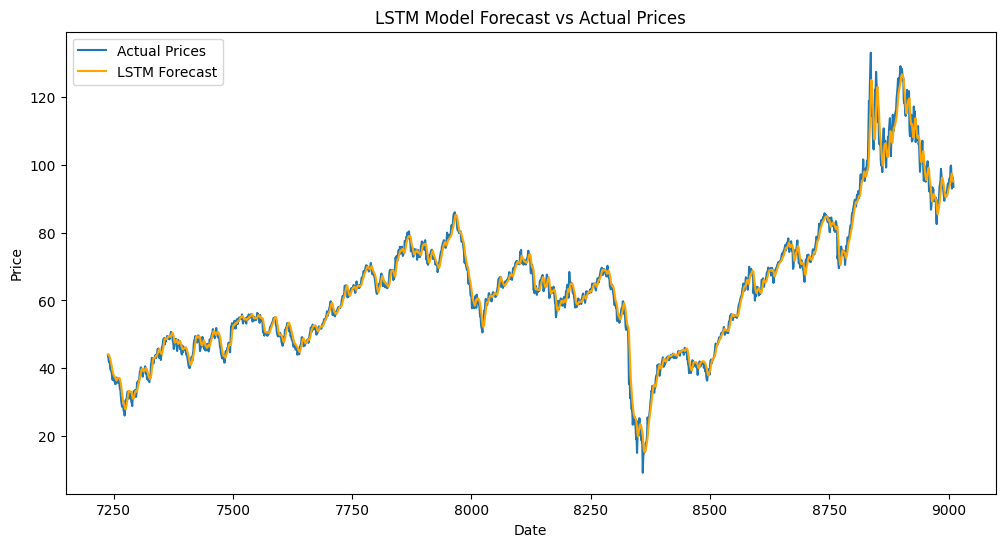

In [17]:
# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Rescale back to original values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale y_test for comparison

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(test.index[sequence_length:], y_test_actual, label='Actual Prices')
plt.plot(test.index[sequence_length:], predictions, label='LSTM Forecast', color='orange')
plt.title("LSTM Model Forecast vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [18]:
# Calculate performance metrics for LSTM
lstm_mse = mean_squared_error(y_test_actual, predictions)
lstm_mae = mean_absolute_error(y_test_actual, predictions)

print(f"LSTM Model - Mean Squared Error: {lstm_mse}")
print(f"LSTM Model - Mean Absolute Error: {lstm_mae}")

# Compare LSTM with other models
print("\nModel Comparison:")
print(f"ARIMA MSE: {mse}, ETS MSE: {ets_mse}, LSTM MSE: {lstm_mse}")
print(f"ARIMA MAE: {mae}, ETS MAE: {ets_mae}, LSTM MAE: {lstm_mae}")


LSTM Model - Mean Squared Error: 5.6296075788320845
LSTM Model - Mean Absolute Error: 1.6369362852308484

Model Comparison:
ARIMA MSE: 613.4690649804356, ETS MSE: 475.5288010487339, LSTM MSE: 5.6296075788320845
ARIMA MAE: 18.430844823559184, ETS MAE: 16.16868948735412, LSTM MAE: 1.6369362852308484


In [19]:
# Create a models directory if it doesn't exist
os.chdir(r'c:\users\ermias.tadesse\10x\Oil-Price-Insights') 
os.makedirs('models', exist_ok=True)

# Save the model in HDF5 format
model.save('models/lstm_brent_oil_price_model.h5')
print("Model saved to models/lstm_brent_oil_price_model.h5")


Model saved to models/lstm_brent_oil_price_model.h5


#### Code to Load the Model Later

In [23]:
from tensorflow.keras.models import load_model

# Load the model from the saved file
os.chdir(r'c:\users\ermias.tadesse\10x\Oil-Price-Insights\models') 
loaded_model = load_model('lstm_brent_oil_price_model.h5')
print("Model loaded from models/lstm_brent_oil_price_model.h5")

Model loaded from models/lstm_brent_oil_price_model.h5
